# AirQo Ugandan Air Quality forecast 

In this project we aim to predict the air quality (measured as fine particles or PM2.5). We were given sensor data of wind speed, wind direction, relative humidity, precipitation, temperature and air pressure. These were given in 5-days intervals containing hourly measures. With these we predict the air quality 24h after the last measurement (given in the train data as "target").  

We applied different machine learning algorithms (i.e. random Random Forest Regressor, KNN regressor and XBGR Regressor) and used grid search and cross validation to find the best hyperparameters to improve our models. Finally, we used stacking to combine the results of the models to make the best prediction.


**Structure of this notebook**

1. Overview of the dataset
1. Imputing missing data
2. Feature engineering
3. Make baseline model
4. Modeling
5. Hyperparameter tuning (with the best types of models)
6. Stacking Regressor using the best types of models
8. Model evaluation

In [1]:
import air_quality_functions as aqf

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor  
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

## 1. Overview of the dataset

In [2]:
# for test data no target defined, we treat the "train" data as the whole dataset
df = pd.read_csv("./data/Train.csv") 

In [3]:
df.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


In [4]:
# convert string entries with measurement values into lists
features = ["temp", "precip", "rel_humidity", "wind_dir", "wind_spd", "atmos_press"]
df = aqf.convert_str_to_list(df, features)

In [5]:
# Split dataset into train and test data
y = df.target
X = df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Adding metadata about the sensor locations

In [6]:
# read .csv file
metadata = pd.read_csv("./data/airqo_metadata.csv")

# calculate fireplaces per km2 for each location
metadata['fires_per_km2'] = (metadata.hh_cook_charcoal + metadata.hh_cook_firewood + metadata.hh_burn_waste) / metadata.km2

# calculate atmospheric standard pressure for each location and add new column to metadata df
metadata['std_pressure'] = aqf.calc_atmos_press(metadata.loc_altitude) / 1000

In [7]:
metadata[['location', 'fires_per_km2', 'std_pressure']]

,location,fires_per_km2,std_pressure
0,A,364.736842,88.698552
1,B,277.592593,88.352152
2,C,3753.176471,88.112567
3,D,946.250000,90.200405
4,E,658.750000,88.026935


In [8]:
# add new columns with std_pressure and fires_per_km2 (from metadata) to datasets
X_train = X_train.join(metadata[['location', 'fires_per_km2', 'std_pressure']].set_index('location'), on='location')
X_test = X_test.join(metadata[['location', 'fires_per_km2', 'std_pressure']].set_index('location'), on='location')

## 2. Imputing missing data

In [9]:
# impute missing values
X_train = aqf.impute_values(X_train, features, strategy='nearest')
X_test = aqf.impute_values(X_test, features, strategy='nearest')

In [10]:
max_num_of_nans = 50

#drop rows with too many nans from X_train and y_train
for feature in features:
    y_train.drop(X_train[X_train[feature + '_nans'] > max_num_of_nans].index, inplace = True)
    X_train.drop(X_train[X_train[feature + '_nans'] > max_num_of_nans].index, inplace = True)

In [11]:
#drop number_of_non_columns
for feature in features:
    X_train.drop(feature + '_nans',axis=1,inplace=True)
    X_test.drop(feature + '_nans',axis=1,inplace=True)

In [12]:
#add columns with min, max etc
for feature in features:
    X_train = aqf.aggregate_features(X_train,feature)
    X_test = aqf.aggregate_features(X_test,feature)

## 3. Feature engineering

Ideas for feature engineering:

* replace location columns with other information (e.g. num of households with charcoal fireplaces)
* add differences from one 6-hour block to the next as new columns &rarr; trend might be an important feature for the model
* correct atmospheric pressure by the altitude of the sensor (sensor altitude is like a constant offset)

In [13]:
# combine individual values in time blocks using their mean
blocksize = 6

X_train = aqf.time_blocks(X_train, features, blocksize)
X_test = aqf.time_blocks(X_test, features, blocksize)

In [14]:
# drop unnecessary columns
# min and median precipitations are always 0 for this dataset
X_train.drop(['ID', 'min_precip', 'median_precip'],axis=1,inplace=True)
X_test.drop(['ID', 'min_precip', 'median_precip'],axis=1,inplace=True)

In [15]:
# correct atmospheric pressure by standard pressure for that altitude
X_train = aqf.correct_pressure(X_train)
X_test = aqf.correct_pressure(X_test)

In [16]:
# add differences (trends) between time block columns to the datasets
X_train = aqf.agg_diffs(X_train, features, blocksize)
X_test = aqf.agg_diffs(X_test, features, blocksize)

### One hot encoding

In [17]:
# do one-hot encoding for location column
X_train = pd.get_dummies(X_train, columns=['location'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['location'], drop_first=True)

## 4. Baseline Model

In [18]:
# Baseline model is just using one feature: 'mean_wind_spd'
# Assumption: more wind speed -> cleaner air
lin_reg = LinearRegression()
lin_reg.fit(X_train[['mean_wind_spd']], y_train)

LinearRegression()

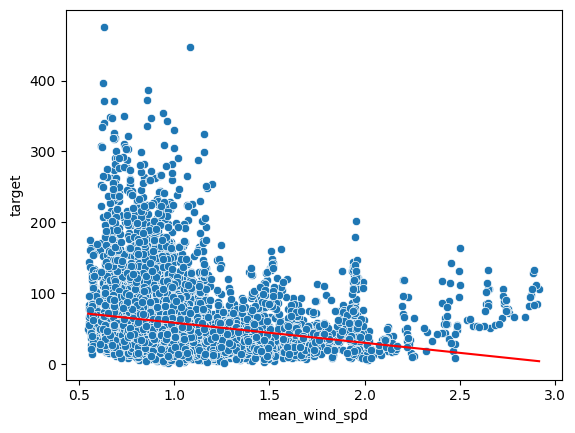

In [19]:
# plot datapoints for mean wind speed and the baseline model
sns.scatterplot(x=X_train['mean_wind_spd'], y=y_train)

# plot line from linear regression model
b0 = lin_reg.intercept_
b1 = lin_reg.coef_[0]
line_x = np.linspace(X_train.mean_wind_spd.min(), X_train.mean_wind_spd.max(), 200)
line_y = (line_x * b1) + b0
plt.plot(pd.DataFrame(line_y, line_x), 'r')

In [20]:
#calculate predicted values of the baseline model
y_train_pred_base = lin_reg.predict(X_train[['mean_wind_spd']])
y_test_pred_base = lin_reg.predict(X_test[['mean_wind_spd']])

print('Baseline model:')
print('RMSE train data: ', mean_squared_error(y_train,y_train_pred_base, squared=False))
print('RMSE test data: ', mean_squared_error(y_test,y_test_pred_base, squared=False))

Baseline model:
RMSE train data:  41.567708595103255
RMSE test data:  43.92745197153489


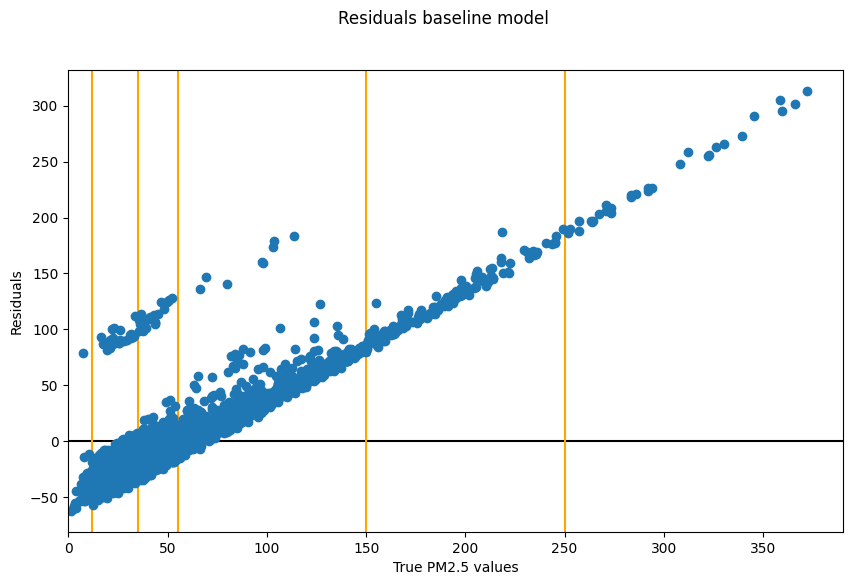

In [21]:
#calculate residuals
residuals = y_test - y_test_pred_base

# hazard category limits 
hazard_lims = [12.0, 35.0, 55.0, 150.0, 250.0]

# plot residuals
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, residuals, zorder=2)
for lim in hazard_lims:
    plt.axvline(lim, c='orange', zorder=1)
plt.axhline(0, c='black', zorder=0)
ax.set_xlim(0)
ax.set_ylabel("Residuals")
ax.set_xlabel("True PM2.5 values")
fig.suptitle('Residuals baseline model')
plt.show()

In [22]:
ax.get_ylim()

(-80.67140226467528, 332.0172094154793)

### Milestone - Baseline model

Value of Product:
* Predict air quality to protect people from hazardous conditions

Prediction:
* Air quality score (PM2.5 value)

Evaluation Metric:
* Root-Mean-Squared-Error (RMSE) (also recommended by Zindi)

Baseline Model:
* simple linear regression with the idea: higher wind speed = cleaner air

Score Baseline Model:
* RMSE = 44.1

## 5. Modeling



### Scaling

In [23]:
from sklearn.preprocessing import StandardScaler

# Columns with numerical values
col_scale = X_train.columns.drop(['location_B', 'location_C', 'location_D', 'location_E'])

# reset indices because some lines have been dropped while imputing
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Scaling with standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

# Change type to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_scale)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_scale)

In [24]:
# Concatenating scaled and dummy columns 
X_train = pd.concat([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test = pd.concat([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

### Try out 7 different regression models

In [25]:
model_dectree_reg = DecisionTreeRegressor(max_features=100, max_depth=20, criterion='squared_error', random_state=RSEED)
model_adaboost    = AdaBoostRegressor(random_state=RSEED)
model_svr         = SVR()
model_sgdr        = SGDRegressor(random_state=RSEED)
model_rfr         = RandomForestRegressor(random_state=RSEED)
model_knr         = KNeighborsRegressor()
model_xgbr        = XGBRegressor()

models = [model_dectree_reg, model_adaboost, model_svr, model_sgdr, model_rfr, model_knr, model_xgbr]

for model in tqdm(models):
    aqf.train_predict_evaluate(model, X_train, y_train, X_test, y_test)

 14%|█▍        | 1/7 [00:00<00:05,  1.12it/s]

Model: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RMSE on train data: 7.5220075247332066
RMSE on test data: 38.108424673920375
-----------------------------


 29%|██▊       | 2/7 [00:17<00:49,  9.87s/it]

Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
RMSE on train data: 50.58304496330107
RMSE on test data: 51.33032215590466
-----------------------------


 43%|████▎     | 3/7 [01:04<01:48, 27.20s/it]

Model: <class 'sklearn.svm._classes.SVR'>
RMSE on train data: 37.87115978079006
RMSE on test data: 38.7630933698391
-----------------------------


 57%|█████▋    | 4/7 [01:05<00:49, 16.59s/it]

Model: <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>
RMSE on train data: 35.24968075330187
RMSE on test data: 38.3735970616304
-----------------------------


 71%|███████▏  | 5/7 [03:44<02:16, 68.03s/it]

Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.583496564067099
RMSE on test data: 25.973066723435533
-----------------------------


 86%|████████▌ | 6/7 [03:47<00:45, 45.96s/it]

Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 22.173421091273152
RMSE on test data: 29.855310519625732
-----------------------------


100%|██████████| 7/7 [03:53<00:00, 33.39s/it]

Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 8.967349006414217
RMSE on test data: 25.960156608941265
-----------------------------


| Model                          | Performance on first iteration    | Performance with additional feature eng. |
| ------------------------------ | --------------------------------: | --: |
| DecisionTreeRegressor          | train:  5.73  test: 40.18     | train:  7.52   test: 38.10  |
| AdaBoostRegressor              | train: 41.66  test: 43.49     | train: 50.58   test: 51.33  |
| SVR                            | train: 38.19  test: 39.35     | train: 37.87   test: 38.76  |
| SGDRegressor                   | train: 34.22  test: 37.67     | train: 35.24   test: 38.37  |
| RandomForestRegressor          | train:  9.20  test: 26.74     | train:  9.58   test: 25.97  |
| KNeighborsRegressor            | train: 21.64  test: 31.09     | train: 22.17   test: 29.85  |
| XGBRegressor                   | train:  8.66  test: 29.17     | train:  8.96   test: 25.96  |
| RandomForestRegressor after GS | train:  9.11  test: 26.12     | train:  9.57   test: 25.80  |
| KNeighborsRegressor after GS   | train:  0.00  test: 27.99     | train:  0.00   test: 26.77  |
| XGBRegressor after GS          | train:  8.36  test: 26.15     | train:  8.94   test: 25.58  |


## 6. Hyperparameter tuning (with the best types of models)

In [26]:
model_rfr = RandomForestRegressor(random_state=RSEED)
model_knr = KNeighborsRegressor()
model_xgbr = XGBRegressor()

models = [model_rfr, model_knr, model_xgbr]

# parameter lists for tuning
parameters_rfr = {
                #'n_estimators':[95, 100, 105],                
                'max_features':[55, 60, 65],               
                #'max_depth' : [35, 100], 
                #'min_samples_split': [2,4,6]
                } 
parameters_knr = {
                'n_neighbors':[5, 10],                
                'metric':['euclidean', 'manhattan'],               
                'weights':['uniform', 'distance'],                         
                } 
parameters_xgbr = {
                'eta': [0.1, 0.3, 0.5],
                'max_depth': [4, 6, 8],
                'eval_metric': ['rmse']
                }

params = [parameters_rfr, parameters_knr, parameters_xgbr]

best_models = []
for model, param in zip(models, params):
    best_models.append(aqf.grid_search_evaluate(model, param, X_train, y_train, X_test, y_test))


Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.574738636693587
RMSE on test data: 25.804804841441324
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 0.0
RMSE on test data: 26.775514341052194
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 8.94285278225819
RMSE on test data: 25.589138116676693
-----------------------------


In [27]:
# for model in best_models:
#     print(model, '\n', model.get_params(), '\n')

## 7. Stacking Regressor Model

In [28]:
estimators = [  ('rfr', RandomForestRegressor(max_features=55, random_state = RSEED)),
                ('knr', KNeighborsRegressor(n_neighbors=5, metric="manhattan", )),
                ('xgbr', XGBRegressor())]

model_stack = StackingRegressor(estimators = estimators, final_estimator = LinearRegression(), cv=3, n_jobs=-1)
model_stack.fit(X_train, y_train).score(X_test, y_test)

y_train_pred_stack = model_stack.predict(X_train)
y_test_pred_stack = model_stack.predict(X_test)

print(f"RMSE on train data: {mean_squared_error(y_train, y_train_pred_stack, squared=False)}")
print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred_stack, squared=False)}")

RMSE on train data: 8.216403840817227
RMSE on test data: 24.484337070388865


## 8. Model evaluation

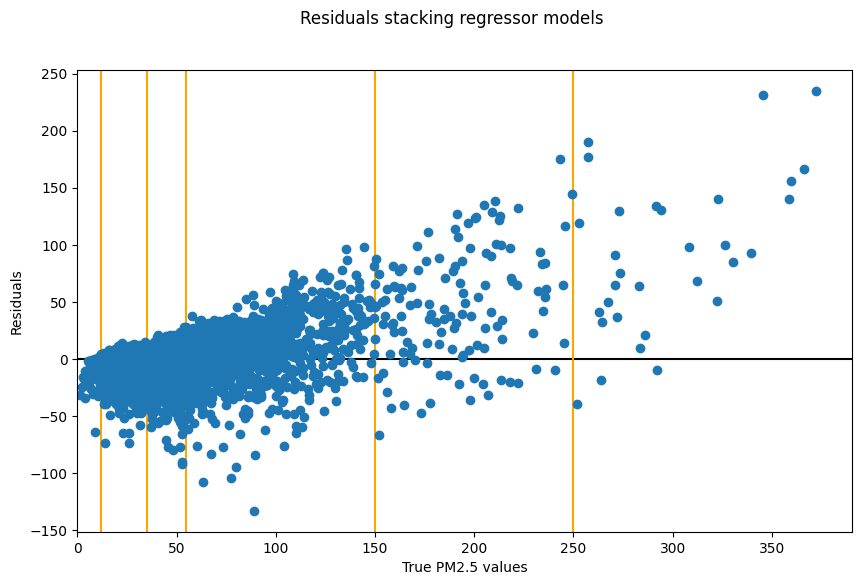

In [29]:
#calculate residuals
residuals = y_test - y_test_pred_stack

# plot residuals
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, residuals, zorder=2)
for lim in hazard_lims:
    plt.axvline(lim, c='orange', zorder=1)
plt.axhline(0, c='black', zorder=0)
ax.set_xlim(0)
ax.set_ylabel("Residuals")
ax.set_xlabel("True PM2.5 values")
fig.suptitle('Residuals stacking regressor models')
plt.show()

In [30]:
# evaluate air quality hazard levels from pm2.5 values
y_train_levels = pd.Series(y_train).apply(aqf.hazard_level)
y_test_levels = pd.Series(y_test).apply(aqf.hazard_level)

In [31]:
y_train_pred_stack_levels = pd.Series(y_train_pred_stack).apply(aqf.hazard_level)
y_test_pred_stack_levels = pd.Series(y_test_pred_stack).apply(aqf.hazard_level)

0.633976833976834
0.6282495418695677


Text(0.5, 1.0, 'Confusion Matrix Stacking Model')

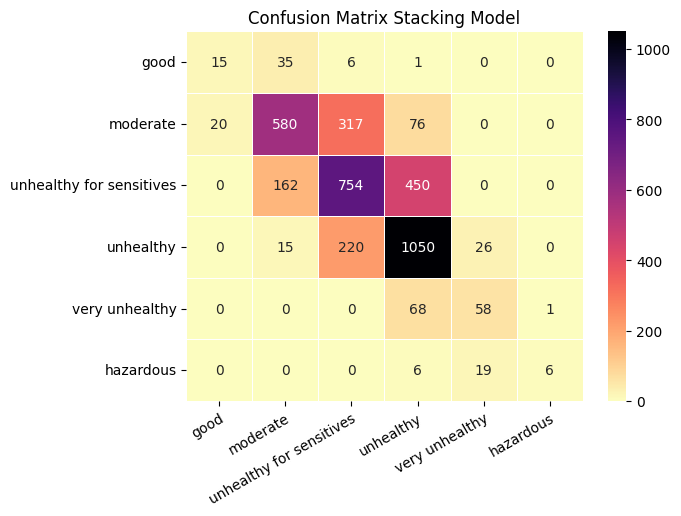

In [33]:
hazard_labels = ['good', 'moderate', 'unhealthy for sensitives', 'unhealthy', 'very unhealthy', 'hazardous']

cm = confusion_matrix(y_test_levels, y_test_pred_stack_levels, labels=hazard_labels)
# print(cm)
print(accuracy_score(y_test_levels, y_test_pred_stack_levels))
print(f1_score(y_test_levels, y_test_pred_stack_levels, average='weighted'))

sns.heatmap(cm, cmap='magma_r', annot=True, fmt='d', linewidths=.5, xticklabels=hazard_labels, yticklabels=hazard_labels);
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
plt.title('Confusion Matrix Stacking Model')

### Comparison to baseline model

0.36653796653796655
0.279655046559115


Text(0.5, 1.0, 'Confusion Matrix Baseline Model')

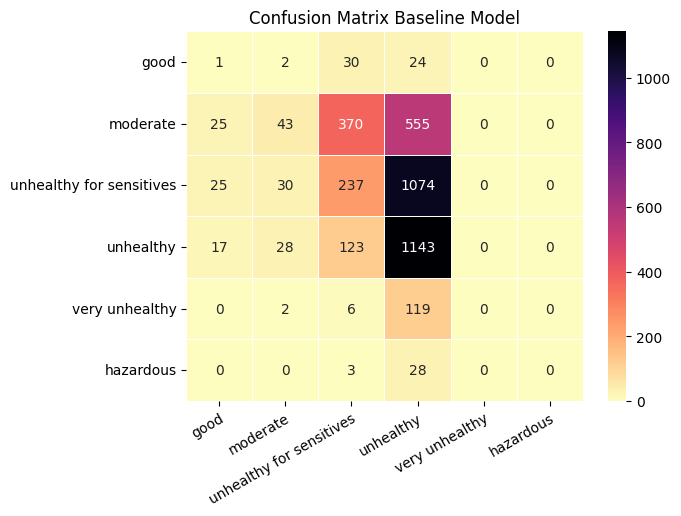

In [34]:
y_train_pred_base_levels = pd.Series(y_train_pred_base).apply(aqf.hazard_level)
y_test_pred_base_levels = pd.Series(y_test_pred_base).apply(aqf.hazard_level)

cm = confusion_matrix(y_test_levels, y_test_pred_base_levels, labels=hazard_labels)
# print(cm)
print(accuracy_score(y_test_levels, y_test_pred_base_levels))
print(f1_score(y_test_levels, y_test_pred_base_levels, average='weighted'))


sns.heatmap(cm, cmap='magma_r', annot=True, fmt='d', linewidths=.5, xticklabels=hazard_labels, yticklabels=hazard_labels);
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
plt.title('Confusion Matrix Baseline Model')